# GQN With DGF - Pool Representation and 8 Generative Steps

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gqn import GenerativeQueryNetwork, partition
from dataset import GQN_Dataset
from torch.distributions import Normal
import shutil
import os
import numpy as np
import cv2
import torch
import glob

In [2]:
df = pd.read_csv("main.log")
print("Total steps: {}".format(df["step"].tolist()[-1]))
models = glob.glob("checkpoints/checkpoint_model_*.pth")
models.sort(key=lambda x: os.path.getmtime(x))
print("Last model checkpoint: {}".format(models[-1]))

Total steps: 509980
Last model checkpoint: checkpoints/checkpoint_model_190000.pth


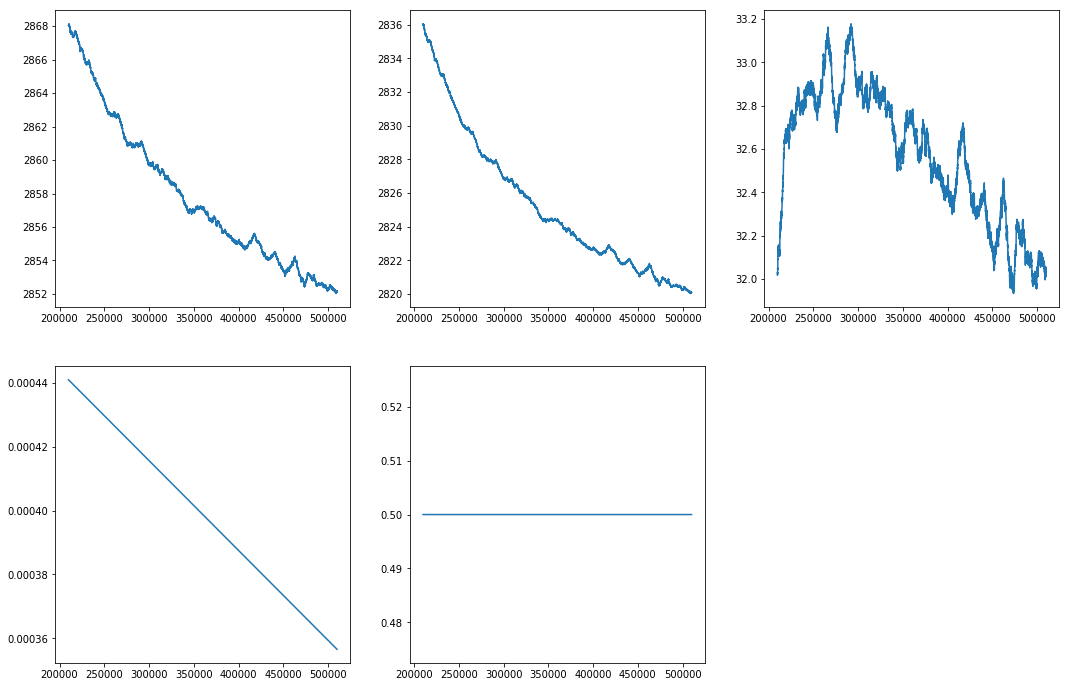

In [4]:
df = df[df["step"]>200000]
# df = df[df["step"]>0]
step = df["step"].to_list()
ll = df["ll"].to_list()
kl = df["kl"].to_list()
elbo = df['elbo'].to_list()
sigma = df['sigma'].to_list()
mu = df['mu'].to_list()
kl_av = []
ll_av = []
elbo_av = []

average_step = 1000
for i in range(average_step, len(step)):
    kl_av.append(sum(kl[i-average_step:i])/average_step)
    ll_av.append(sum(ll[i-average_step:i])/average_step)
    elbo_av.append(sum(elbo[i-average_step:i])/average_step)
step = step[average_step:]
sigma = sigma[average_step:]
mu =mu[average_step:]

plt.figure(num=None, figsize=(18, 12))
plt.subplot(231)
plt.plot(step, elbo_av)
plt.subplot(232)
plt.plot(step, ll_av)
plt.subplot(233)
plt.plot(step, kl_av)

plt.subplot(234)
plt.plot(step, mu)
plt.subplot(235)
plt.plot(step, sigma)
plt.show()

0


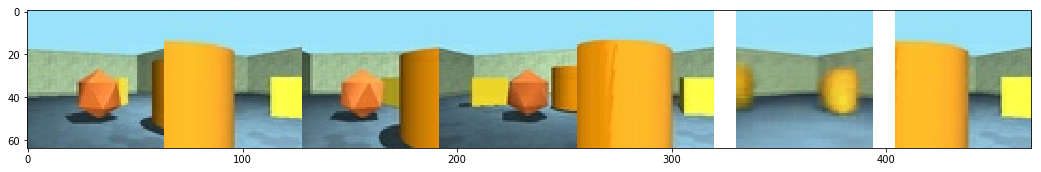

1


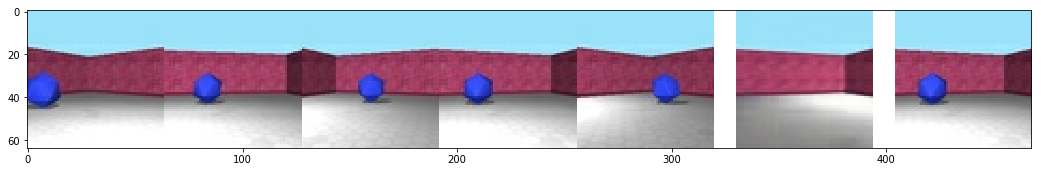

2


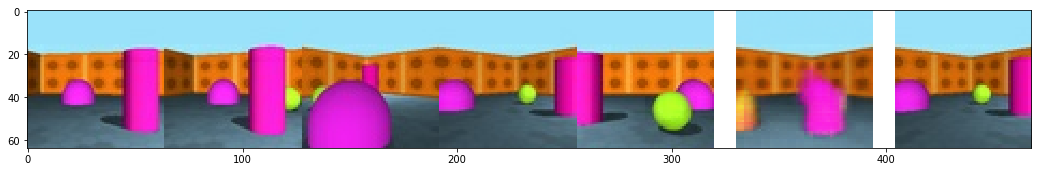

3


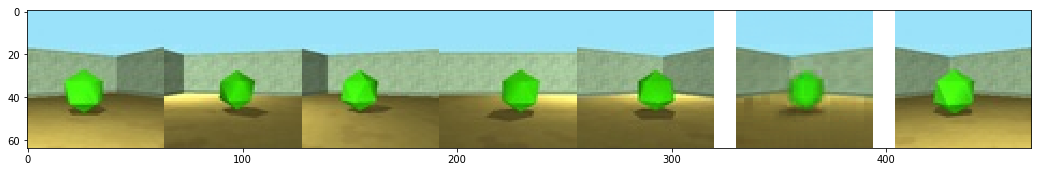

4


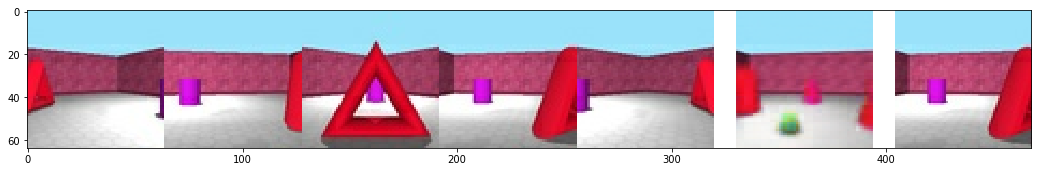

5


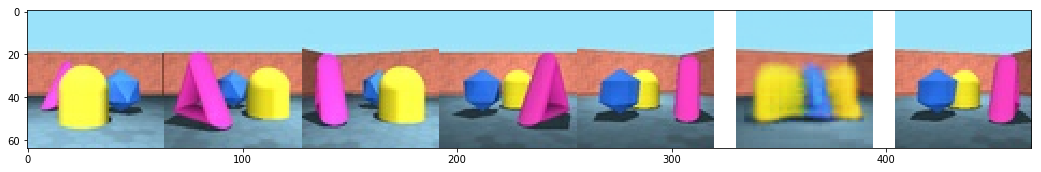

6


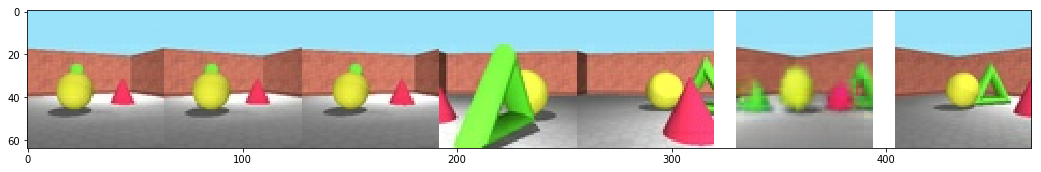

7


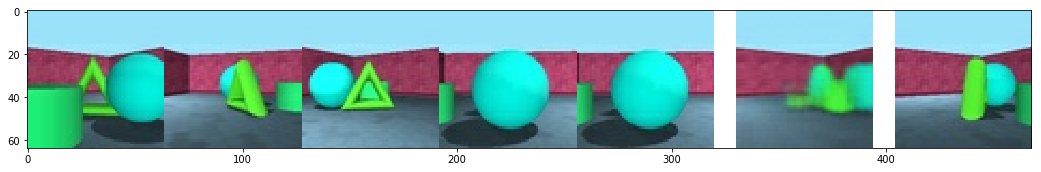

8


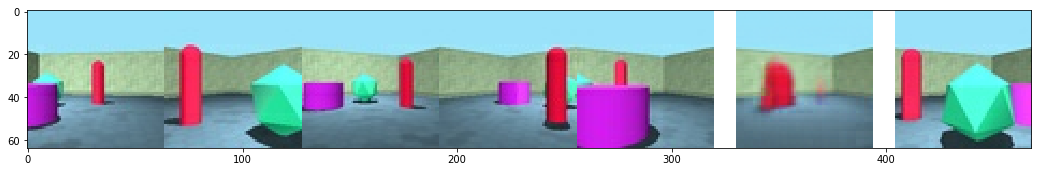

9


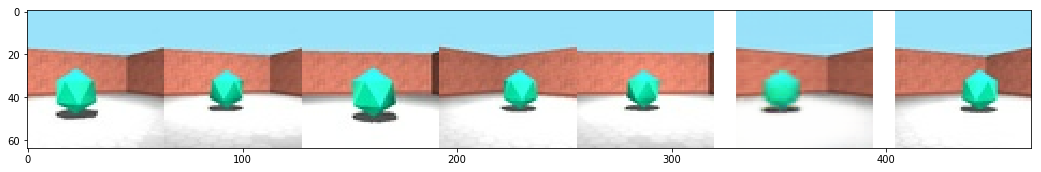

10


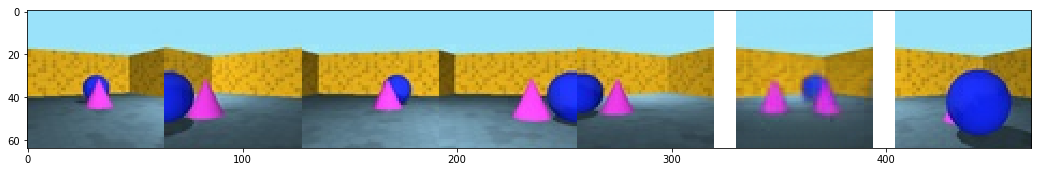

11


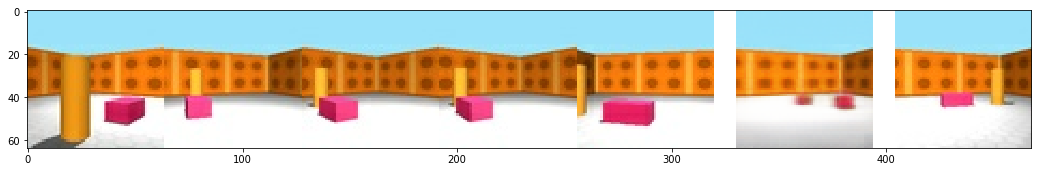

12


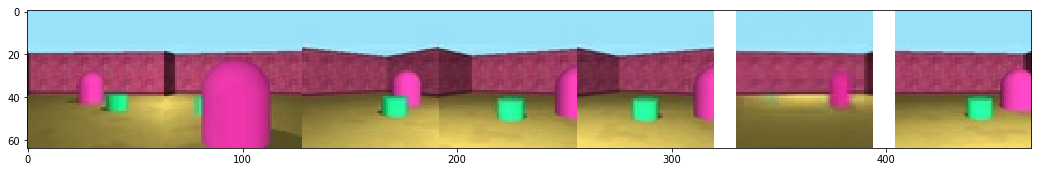

13


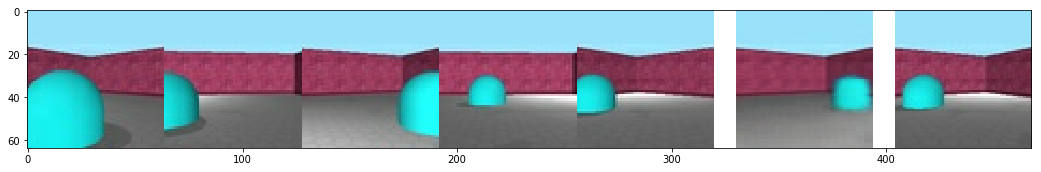

14


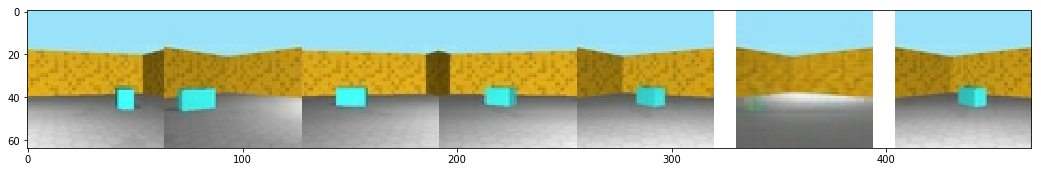

15


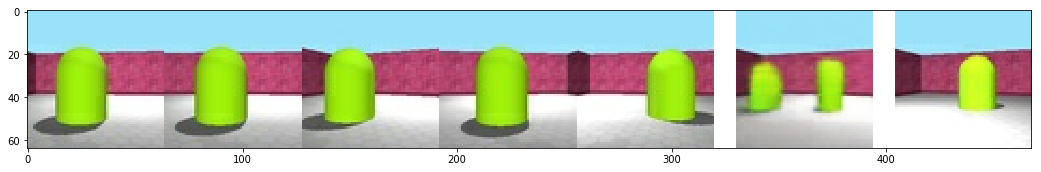

16


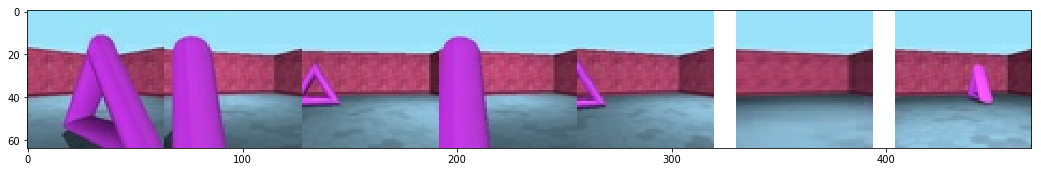

17


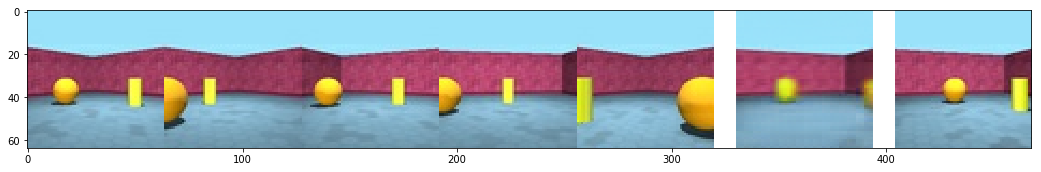

18


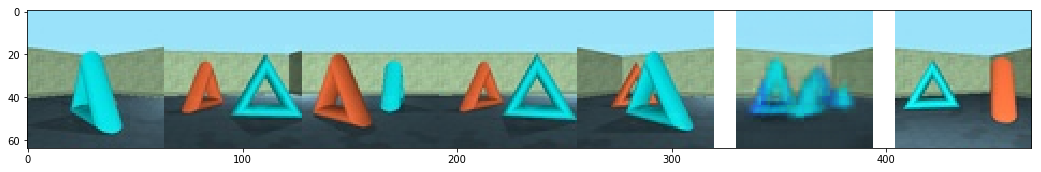

19


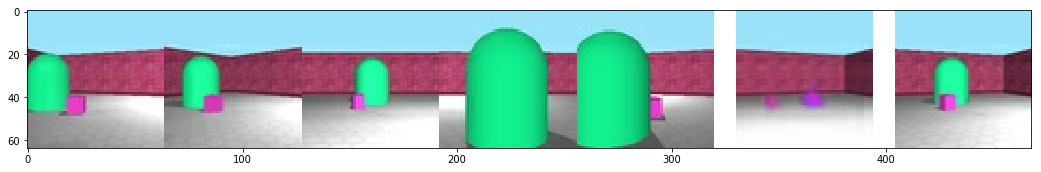

20


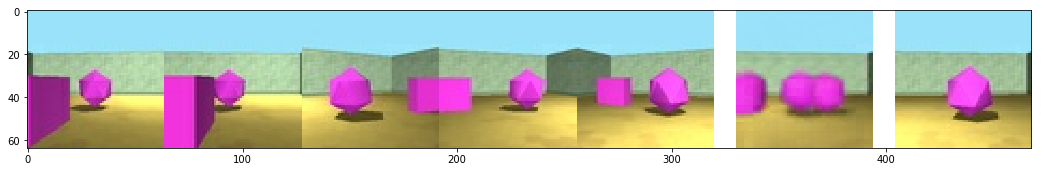

21


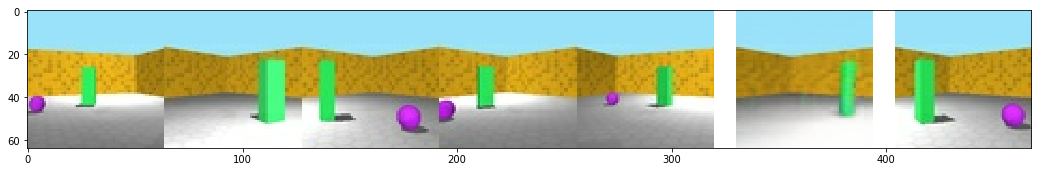

22


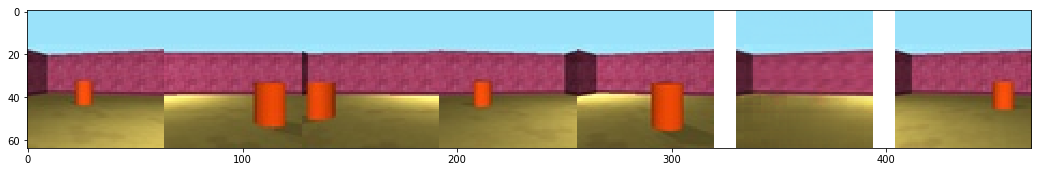

23


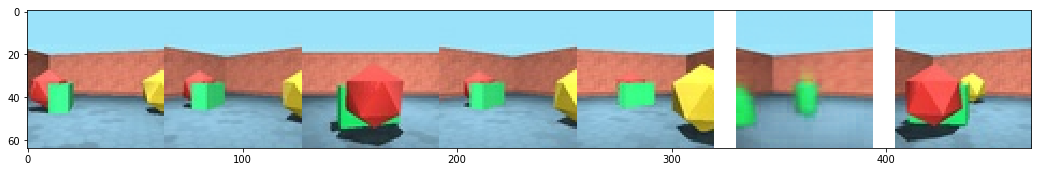

24


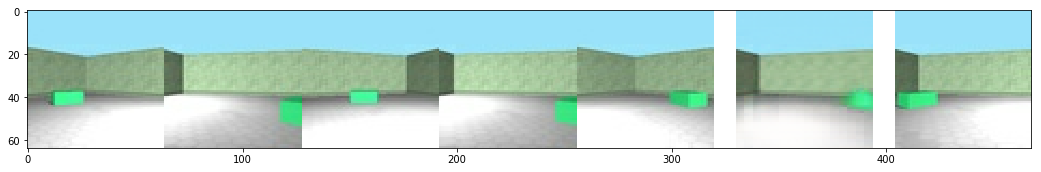

25


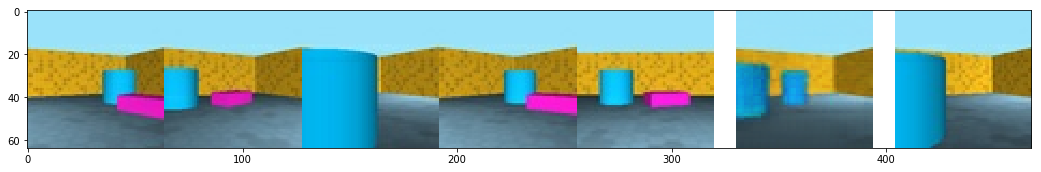

26


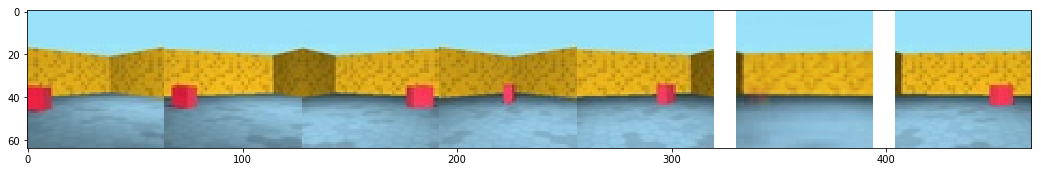

27


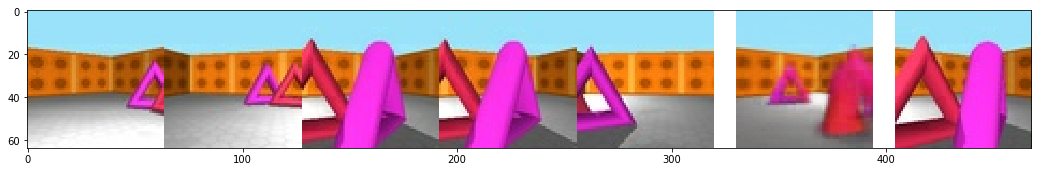

28


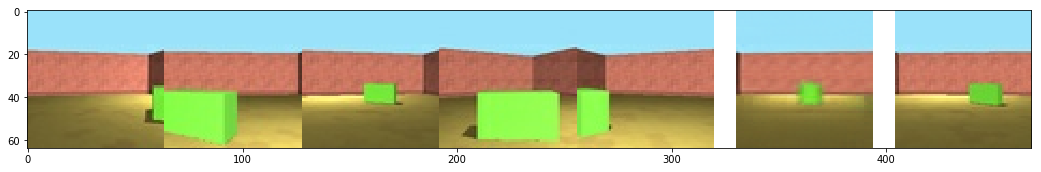

29


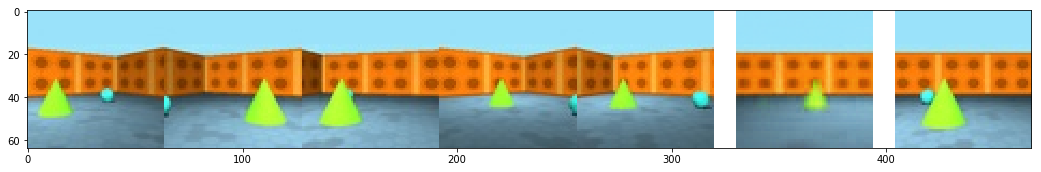

30


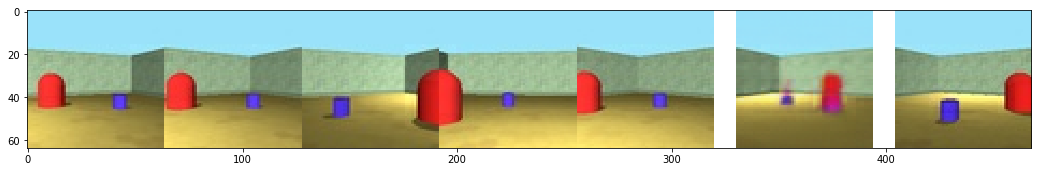

31


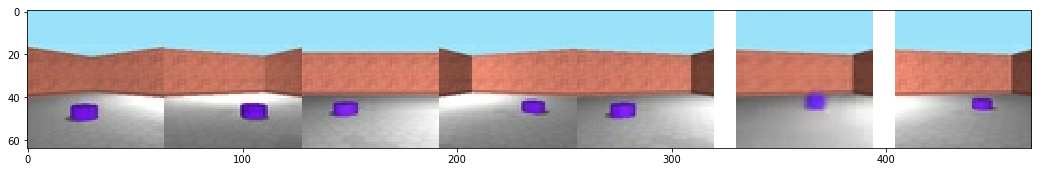

32


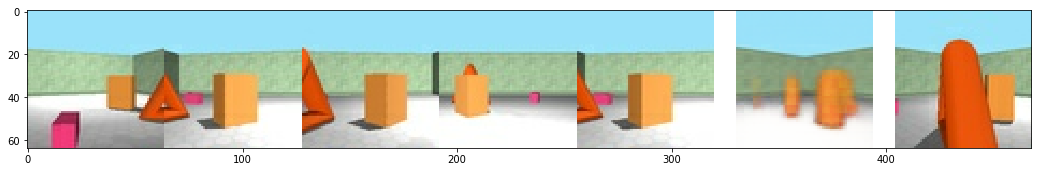

33


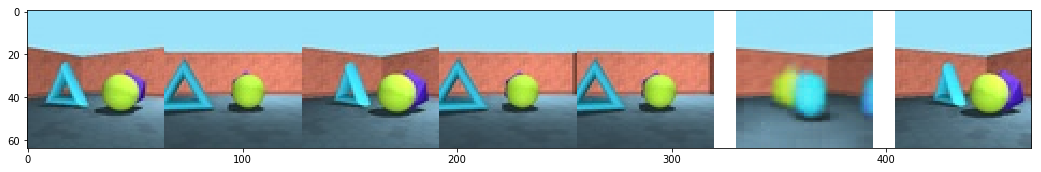

34


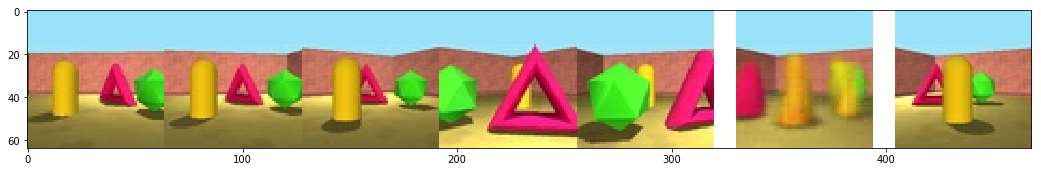

35


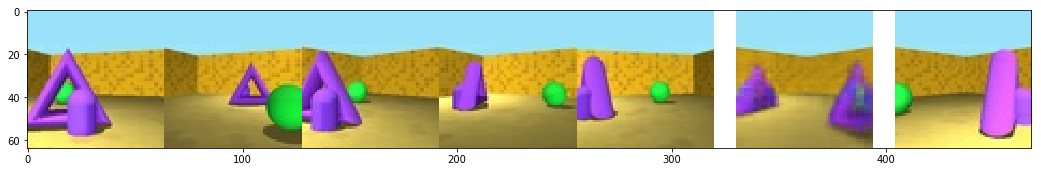

In [32]:
device = torch.device("cpu")

valid_dataset = GQN_Dataset(root_dir="data/rooms_ring_camera/", train=False)
x, v = valid_dataset[1]
x = x.view((1, *x.shape))
v = v.view((1, *v.shape))
x, v = x.to(device), v.to(device)
max_m=5
x, v, x_q, v_q = partition(x, v, max_m, 5)
batch, *_ = x.shape

model = GenerativeQueryNetwork(x_dim=3, v_dim=7, r_dim=256, h_dim=128, dgf_dim=256, z_dim=64, L=8, pool=True).to(device)
model.train()
checkpoint = torch.load(models[-1])
# checkpoint = torch.load("./checkpoints/checkpoint_model_40000.pth") #
# checkpoint = torch.load("./wo-batch/checkpoint_model_170000.pth")
model.load_state_dict(checkpoint)

x_mu, bn1_stats, bn2_stats = model.sample(x, v, v_q)
# x_mu, r, kl = model(x, v, x_q, v_q)
x_mu_orig = x_mu.detach().cpu().numpy()
context_x = x.cpu().numpy()
query_x = x_q.cpu().numpy()

context_x = np.moveaxis(context_x, [2, 3, 4], [-1, 2, 3])
query_x = np.moveaxis(query_x, [1, 2, 3], [-1, -3, -2])
x_mu = np.moveaxis(x_mu_orig, [1, 2, 3], [-1, -3, -2])

n = 36
for i in range(n):
    full = np.concatenate(context_x[i], axis=1)
    space = np.ones(shape=(full.shape[0], 10, 3))
    full = np.concatenate([full, space, x_mu[i], space, query_x[i]], axis=1)
    plt.figure(num=None, figsize=(18, 6))
    plt.imshow(full)
    print(i)
    plt.show()



In [ ]:
#i = 9
i = 34

In [ ]:
delta = 0.06
new_images = 7
change_n = 256
batch = 1

_, _, x_dims, h, w = x.shape

dgf = model.get_dgf(x, v, bn1_stats)[i]
dgf = dgf.cpu().detach().numpy()

view_q = v_q[i].cpu().detach().numpy()
view_q = np.reshape(view_q, (1,  view_q.shape[0]))
view_q = torch.tensor(view_q)

biases = model.input_layer.bias.cpu().detach().numpy()

deltas = [delta * (j - new_images//2) for j in range(new_images)]
for neuron_i in range(change_n):
    delta_set = []
    images = []
    for cur_delta in deltas:
        new_dgf = np.copy(dgf)
        new_dgf.astype(np.float16)
        new_dgf[neuron_i] += cur_delta
        delta_set.append("{:.5}".format(new_dgf[neuron_i]))
        new_dgf = np.expand_dims(new_dgf, axis=0)
        new_dgf = torch.tensor(new_dgf)

        device = torch.device("cpu")
        new_dgf, view_q = new_dgf.to(device), view_q.to(device)
        torch.manual_seed(3)
        x_mu = model.sample_from_dgf((batch, h, w), new_dgf, view_q, bn2_stats)
        x_mu = x_mu.detach().cpu().numpy()
        images.append(x_mu)

    images = np.array(images)
    images = np.reshape(images, (new_images, x_dims, h, w))
    images = np.moveaxis(images, [1, 2, 3], [-1, -3, -2])
    images = np.concatenate(images, axis=1)
    print("i: {}, bias: {:.4}".format(neuron_i+1, biases[neuron_i]))
    print("      ","        ".join(delta_set))
    plt.figure(num=None, figsize=(21,6))
    plt.imshow(images)
    plt.show()



In [ ]:
delta = 0.1
new_images = 1
change_n = 256
batch = 1

_, _, x_dims, h, w = x.shape

dgf = model.get_dgf(x, v, bn1_stats)[i]
dgf = dgf.cpu().detach().numpy()

view_q = v_q[i].cpu().detach().numpy()
view_q = np.reshape(view_q, (1,  view_q.shape[0]))
view_q = torch.tensor(view_q)

for j in range(200):
    print(j)
    new_dgf = np.copy(dgf)
    new_dgf.astype(np.float16)
    delta_set.append("{:.5}".format(new_dgf[neuron_i]))
    new_dgf = np.expand_dims(new_dgf, axis=0)
    new_dgf = torch.tensor(new_dgf)

    device = torch.device("cpu")
    new_dgf, view_q = new_dgf.to(device), view_q.to(device)
    torch.manual_seed(j)
    x_mu = model.sample_from_dgf((batch, h, w), new_dgf, view_q, bn2_stats)
    x_mu = x_mu.detach().cpu().numpy()[0]
    images = np.moveaxis(x_mu, [0, 1, 2], [-1, -3, -2])
    plt.imshow(images)
    plt.show()
    


In [ ]:
tt = []
for i in range(20):
    x, v = valid_dataset[i]
    x = x.view((1, *x.shape))
    v = v.view((1, *v.shape))
    x, v = x.to(device), v.to(device)
    max_m=5
    x, v, x_q, v_q = partition(x, v, max_m, 5)

    dgf = model.get_dgf(x, v, bn1_stats)
    dgf = dgf.cpu().detach().numpy()
    dgf = np.maximum(dgf, 0)
    dgf = np.sum(dgf, axis=0)
    tt.append(np.sum(dgf==0))

print(sum(tt)/len(tt))
#83.15 - kkur 220
#87.85 - 350
#88.75 - 420


In [13]:
w = model.output_layer.weight.numpy()
products = []
for i in range(256):
    for j in range(i+1, 256):
        w1 = w[i]
        w2 = w[j]
        prod = np.dot(w1, w2)
        products.append(prod)
shift = np.percentile(products, 95)        

(array([2.000e+00, 7.000e+00, 8.000e+00, 2.200e+01, 4.400e+01, 1.080e+02,
        2.060e+02, 4.280e+02, 7.600e+02, 1.099e+03, 1.722e+03, 2.379e+03,
        2.984e+03, 3.444e+03, 3.680e+03, 3.644e+03, 3.312e+03, 2.745e+03,
        2.144e+03, 1.553e+03, 9.890e+02, 6.290e+02, 3.660e+02, 2.020e+02,
        8.000e+01, 4.200e+01, 2.700e+01, 6.000e+00, 4.000e+00, 4.000e+00]),
 array([-0.08832017, -0.08238042, -0.07644067, -0.07050092, -0.06456117,
        -0.05862141, -0.05268166, -0.04674191, -0.04080215, -0.0348624 ,
        -0.02892265, -0.0229829 , -0.01704314, -0.01110339, -0.00516364,
         0.00077612,  0.00671587,  0.01265562,  0.01859537,  0.02453513,
         0.03047488,  0.03641463,  0.04235438,  0.04829414,  0.05423389,
         0.06017364,  0.0661134 ,  0.07205315,  0.0779929 ,  0.08393265,
         0.0898724 ], dtype=float32),
 <a list of 30 Patch objects>)

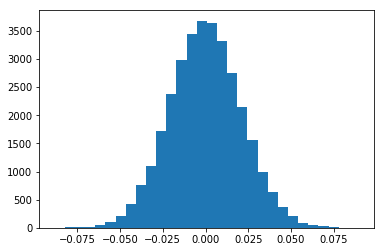

In [14]:
from matplotlib import pyplot as plt
plt.hist(products, bins=30)

In [ ]:
pos = 0
neg = 0
for i in products:
    if i-shift > 0:
        pos+=1
    else:
        neg+=1
print(pos)
print(neg)